In [1]:
import pandas as pd
import json
import os
import re

pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Increase the width of the display
pd.set_option('display.max_colwidth', None)  # Don't truncate text in columns

DATA_SRC = "../sources"  
schema_file_path = "mediated_schema.json"  
with open(schema_file_path, "r", encoding="utf-8") as f:
    schema_data = json.load(f)

companies_keys = list(schema_data["schema"].keys())
companies_df = pd.DataFrame(columns=companies_keys)

employees_keys = list(schema_data['employees'].keys())
emp_df = pd.DataFrame(columns=employees_keys)

In [2]:
display(companies_df)

,company_id,company_name,trade_name,industry,sector,categories,company_status,company_type,headquarters,address,postal_code,city,country,state,continent,foundation_year,registration_date,website,rank,market_cap_or_valuation,number_of_employees,ceo,founder,assets,profit_or_net_income,revenue,total_funding_raised,share_price,change_1_day,change_1_year,debts,phone,sic_code,emtak_code,nace_code,facebook,twitter,pinterest,instagram,investors,region,notes_or_description


In [3]:
display(emp_df)

,company_id,nameEmployee,code,role,startDate,participation,contribution


In [4]:
schema_mapping_path = "schema_mapping.json"
with open(schema_mapping_path, "r", encoding="utf-8") as f:
    field_mapping = json.load(f)

In [5]:
def normalize_strings(value):
    if isinstance(value, str):
        value = re.sub(r'\s+', ' ', value.strip())
        value = value.replace('\\n', '').strip()
        value = value.lower()
    return value

In [6]:
def map_source_to_schema(source_df, field_mapping):
    source_columns = field_mapping.keys()
    mapped_df = source_df[list(source_columns)].copy()
    mapped_df.rename(columns=field_mapping, inplace=True)
    mediated_schema_columns = list(set(field_mapping.values()))

    for column in mediated_schema_columns:
        if column not in mapped_df.columns:
            mapped_df[column] = None
        else:
            mapped_df[column] = mapped_df[column].apply(normalize_strings)
    return mapped_df

In [7]:
def integrate_data(companies_df, transformed_df):
    for column in transformed_df.columns:
        if column not in companies_df.columns:
            companies_df[column] = None  # Add missing columns with None

    # Concatenate along rows (axis=0), ignoring index to avoid conflicts
    integrated_df = pd.concat([companies_df, transformed_df], ignore_index=True)

    return integrated_df

In [8]:
emp_df = pd.DataFrame()
companies_df = pd.DataFrame()

for source_file in os.listdir(DATA_SRC):
    file_path = os.path.join(DATA_SRC, source_file)
    
    if file_path.endswith('.csv'):
        try:
            source_df = pd.read_csv(file_path, encoding='utf-8')
        except UnicodeDecodeError:
            source_df = pd.read_csv(file_path, encoding='ISO-8859-1')
    elif file_path.endswith('.json'):
        with open(file_path, 'r') as f:
            data = json.load(f)
        if isinstance(data, list):
            source_df = pd.json_normalize(data)
        else:
            source_df = pd.json_normalize([data])
    elif file_path.endswith('.xls'):
        source_df = pd.read_excel(file_path)
    elif file_path.endswith('.jsonl'):
        source_df = pd.read_json(file_path, lines=True)

    datasource = os.path.splitext(source_file)[0]
    if source_file.startswith('wissel-partners') or source_file.startswith('wissel-rappresentanti'):
        print(f"Processing {datasource} data, row count: {source_df.shape[0]}")
        temp = map_source_to_schema(source_df, field_mapping['employees_mapping'][datasource])
        emp_df = integrate_data(emp_df, temp)
    else:
        print(f"Processing {datasource} data, row count: {source_df.shape[0]}")
        temp = map_source_to_schema(source_df, field_mapping['companies_mapping'][datasource])
        companies_df = integrate_data(companies_df, temp)


display(companies_df.head(10))
display(emp_df.head(10))

Processing AmbitionBox data, row count: 9899
Processing campaignindia data, row count: 1000
Processing companiesMarketCap_dataset data, row count: 5897
Processing company_social_urls data, row count: 848
Processing DDD-cbinsight.com data, row count: 1185
Processing DDD-teamblind.com data, row count: 946
Processing disfold.com data, row count: 16097
Processing ft.com data, row count: 5000
Processing hitHorizons_dataset data, row count: 667
Processing MalPatSaj-forbes.com data, row count: 2000
Processing MalPatSaj-wikipedia.org data, row count: 3111
Processing output_globaldata data, row count: 5336
Processing output_govuk_bigsize data, row count: 7000
Processing valueToday_dataset data, row count: 10682
Processing wissel-activity-ariregister.rik.ee data, row count: 1015


C:\Users\emigi\AppData\Local\Temp\ipykernel_18636\314414572.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  integrated_df = pd.concat([companies_df, transformed_df], ignore_index=True)


Processing wissel-aziende-ariregister.rik.ee data, row count: 1469
Processing wissel-aziende-info-clipper.com data, row count: 4656
Processing wissel-partners-ariregister.rik.ee data, row count: 1191
Processing wissel-rappresentanti-ariregister.rik.ee data, row count: 1005


,company_name,industry,headquarters,company_type,foundation_year,rank,region,company_id,market_cap_or_valuation,country,share_price,change_1_day,change_1_year,categories,facebook,twitter,instagram,pinterest,registration_date,city,investors,notes_or_description,total_funding_raised,website,number_of_employees,ceo,revenue,address,sic_code,profit_or_net_income,assets,sector,phone,company_status,debts,state,continent,founder,emtak_code,nace_code,trade_name,postal_code
0,tcs,it services & consulting,"mumbai, maharashtra, india",public,1968 (55 yrs old),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None
1,accenture,it services & consulting,"dublin, ireland",public,1989 (34 yrs old),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None
2,cognizant,it services & consulting,"teaneck. new jersey., united states (usa)",private,1994 (29 yrs old),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None
3,icici bank,banking,"mumbai, maharashtra, india",public,1994 (29 yrs old),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None
4,hdfc bank,banking,"mumbai, maharashtra, india",public,1994 (29 yrs old),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None
5,wipro,it services & consulting,"bangalore/bengaluru, karnataka, india",public,1945 (78 yrs old),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None
6,infosys,it services & consulting,"bengaluru/bangalore, karnataka, india",public,1981 (42 yrs old),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None
7,capgemini,it services & consulting,"paris, france",public,1967 (56 yrs old),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None
8,tech mahindra,it services & consulting,"pune, maharashtra, india",public,1986 (37 yrs old),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None
9,genpact,it services & consulting,"new york, new york, united states (usa)",public,1997 (26 yrs old),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None


,company_id,nameEmployee,code,participation,contribution,role,startDate
0,2,janis jegi,38807314918,70.00%,7000.00 eur,None,None
1,2,kaire jegi,48812154914,30.00%,3000.00 eur,None,None
2,3,siim tiigim\xc3\xa4gi,38807042731,100.00%,2500.00 eur,None,None
3,4,dominik gronkiewicz,39207230150,100.00%,2500.00 eur,None,None
4,5,arti haidak,38205186529,50.00%,1250.00 eur,None,None
5,5,rainis luik,37508026514,50.00%,1250.00 eur,None,None
6,6,kaido kaabel,36706040246,44.00%,1122.00 eur,None,None
7,6,marek kaabel,37008100259,44.00%,1122.00 eur,None,None
8,6,arvi kaabel,34111240226,12.00%,306.00 eur,None,None
9,7,kaido kaabel,36706040246,50.00%,1278.00 eur,None,None


In [9]:
display(companies_df.info())
display(emp_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76808 entries, 0 to 76807
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company_name             75793 non-null  object 
 1   industry                 27953 non-null  object 
 2   headquarters             34960 non-null  object 
 3   company_type             17362 non-null  object 
 4   foundation_year          27217 non-null  object 
 5   rank                     17579 non-null  object 
 6   region                   1000 non-null   object 
 7   company_id               31383 non-null  object 
 8   market_cap_or_valuation  30093 non-null  object 
 9   country                  29913 non-null  object 
 10  share_price              6793 non-null   object 
 11  change_1_day             5897 non-null   object 
 12  change_1_year            5648 non-null   object 
 13  categories               15532 non-null  object 
 14  facebook              

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2196 entries, 0 to 2195
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   company_id     2196 non-null   object
 1   nameEmployee   2196 non-null   object
 2   code           2196 non-null   object
 3   participation  1191 non-null   object
 4   contribution   1191 non-null   object
 5   role           1005 non-null   object
 6   startDate      1005 non-null   object
dtypes: object(7)
memory usage: 120.2+ KB


None

In [10]:
emp_df = emp_df.sort_values(by=['nameEmployee'])
companies_df = companies_df.sort_values(by=['company_name'])
comp_columns_order = ["company_id","company_name","trade_name","industry","sector","categories", 
                 "company_status","company_type","headquarters", "address", "postal_code","city", 
                 "country", "state", "continent", "foundation_year", "registration_date", "website", 
                 "rank", "market_cap_or_valuation", "number_of_employees", "ceo", "founder", 
                 "assets", "profit_or_net_income", "revenue", "total_funding_raised", "share_price", 
                 "change_1_day", "change_1_year", "debts", "phone", "sic_code", "emtak_code", "nace_code", 
                 "facebook", "twitter", "pinterest", "instagram", "investors", "region", "notes_or_description"]
companies_df = companies_df[comp_columns_order]

emp_df.to_csv("impiegati.csv", index=False)
companies_df.to_csv("aziende.csv", index=False)

C:\Users\emigi\AppData\Local\Temp\ipykernel_18636\2947755298.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attribute_counts.index, y=attribute_counts.values, palette="viridis")


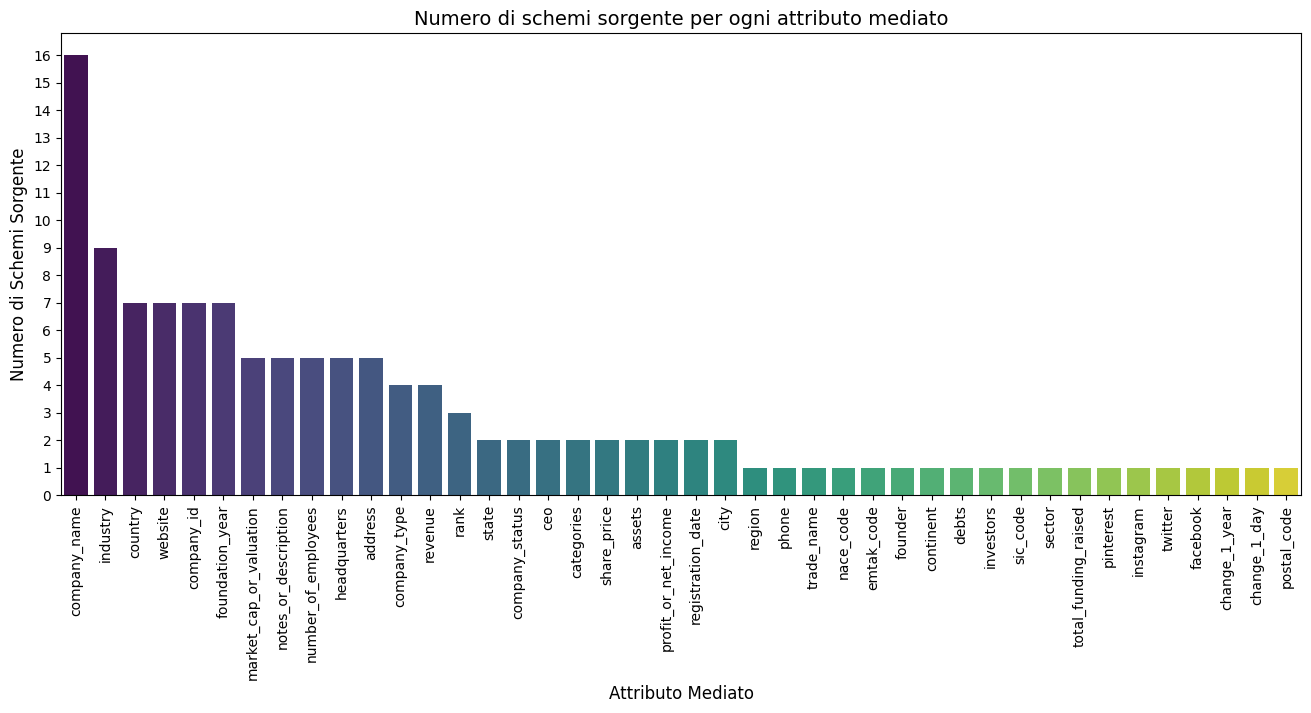

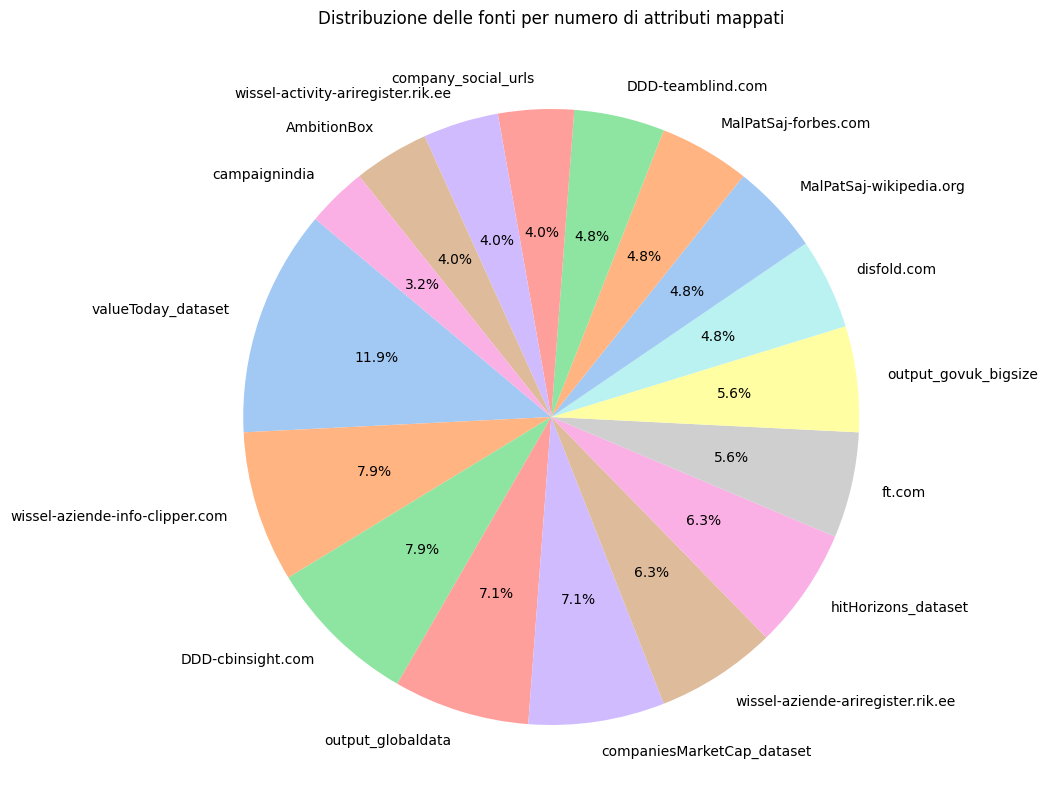

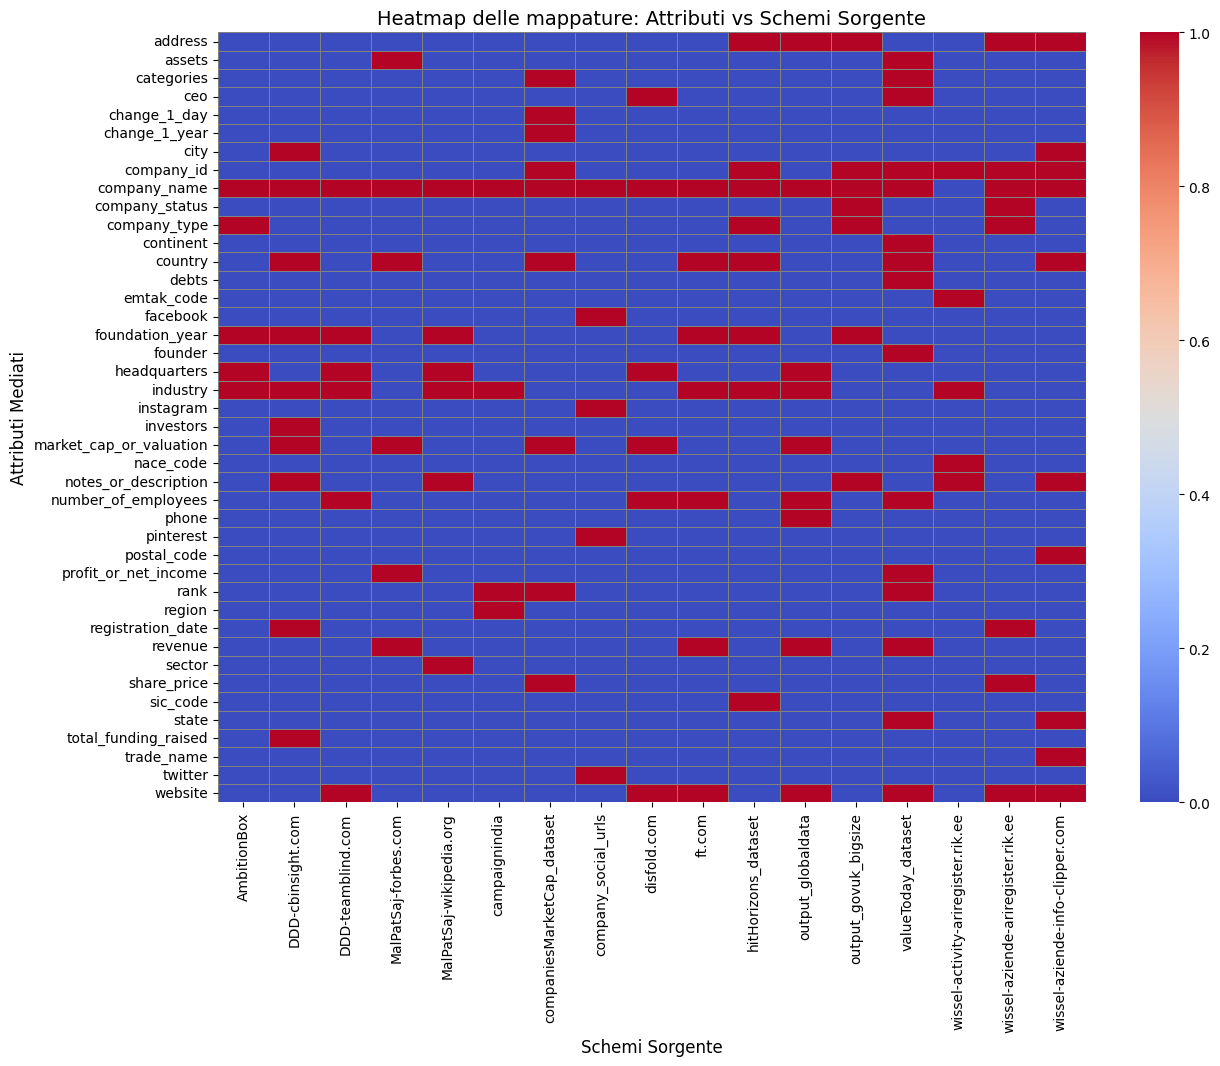

In [15]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Percorso del file JSON
json_path = "../o1-mediated/schema_mapping.json"

# Carica il file JSON
with open(json_path, "r", encoding="utf-8") as file:
    json_data = json.load(file)

# Estrai il mapping delle aziende
companies_mapping = json_data["companies_mapping"]

# Creazione DataFrame per analisi
mapping_list = []
for source, attributes in companies_mapping.items():
    for source_attr, mediated_attr in attributes.items():
        mapping_list.append({"source": source, "mediated_attr": mediated_attr})

df_mappings = pd.DataFrame(mapping_list)

# 🔹 Conteggio di quanti schemi sorgente hanno ogni attributo mediato
attribute_counts = df_mappings["mediated_attr"].value_counts()

# 🔹 Bar Chart: Numero di schemi sorgente per ogni attributo mediato
plt.figure(figsize=(16, 6))
sns.barplot(x=attribute_counts.index, y=attribute_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Numero di schemi sorgente per ogni attributo mediato", fontsize=14)
plt.xlabel("Attributo Mediato", fontsize=12)
plt.ylabel("Numero di Schemi Sorgente", fontsize=12)
plt.yticks(range(0, max(attribute_counts.values) + 1, 1))  # Step regolare
plt.show()

# 🔹 Pie Chart: Distribuzione delle fonti per numero di attributi
source_counts = df_mappings["source"].value_counts()

plt.figure(figsize=(10, 10))
plt.pie(source_counts, labels=source_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Distribuzione delle fonti per numero di attributi mappati")
plt.show()

# 🔹 Heatmap: Attributi vs Fonti
heatmap_df = df_mappings.pivot_table(index="mediated_attr", columns="source", aggfunc="size", fill_value=0)

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_df, cmap="coolwarm", linewidths=0.5, linecolor="gray")
plt.title("Heatmap delle mappature: Attributi vs Schemi Sorgente", fontsize=14)
plt.xlabel("Schemi Sorgente", fontsize=12)
plt.ylabel("Attributi Mediati", fontsize=12)
plt.show()


C:\Users\emigi\AppData\Local\Temp\ipykernel_18636\3923283485.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attribute_counts.index, y=attribute_counts.values, palette="viridis")


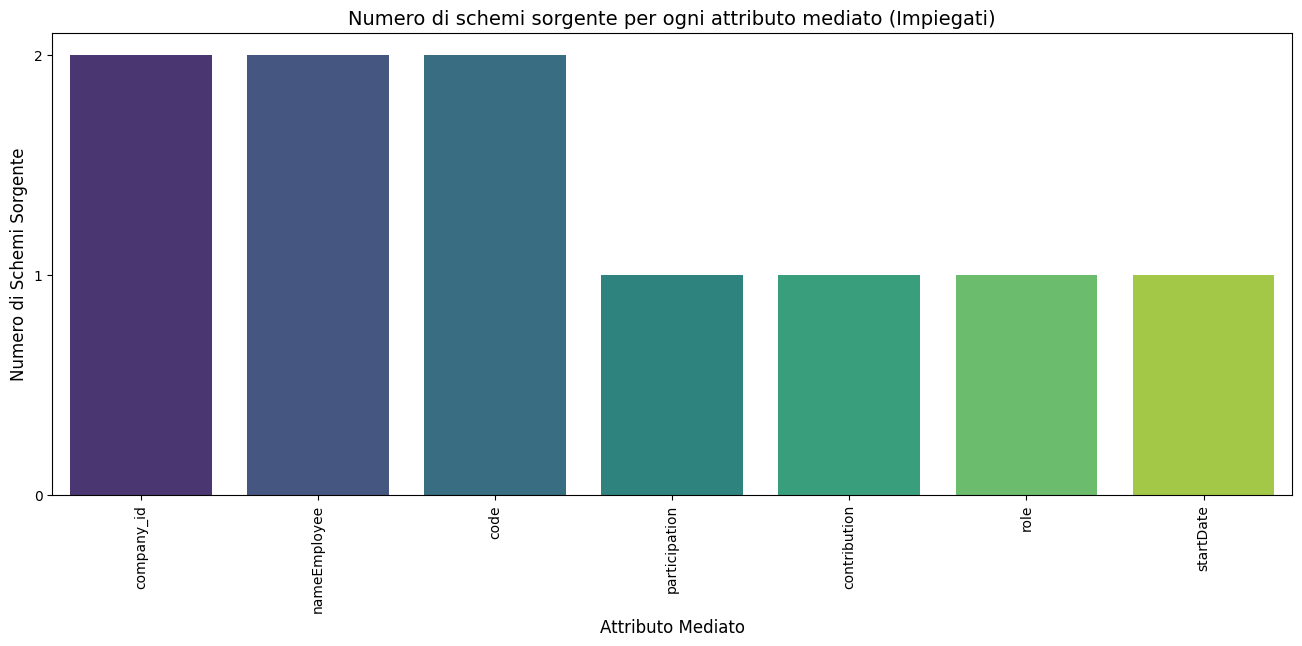

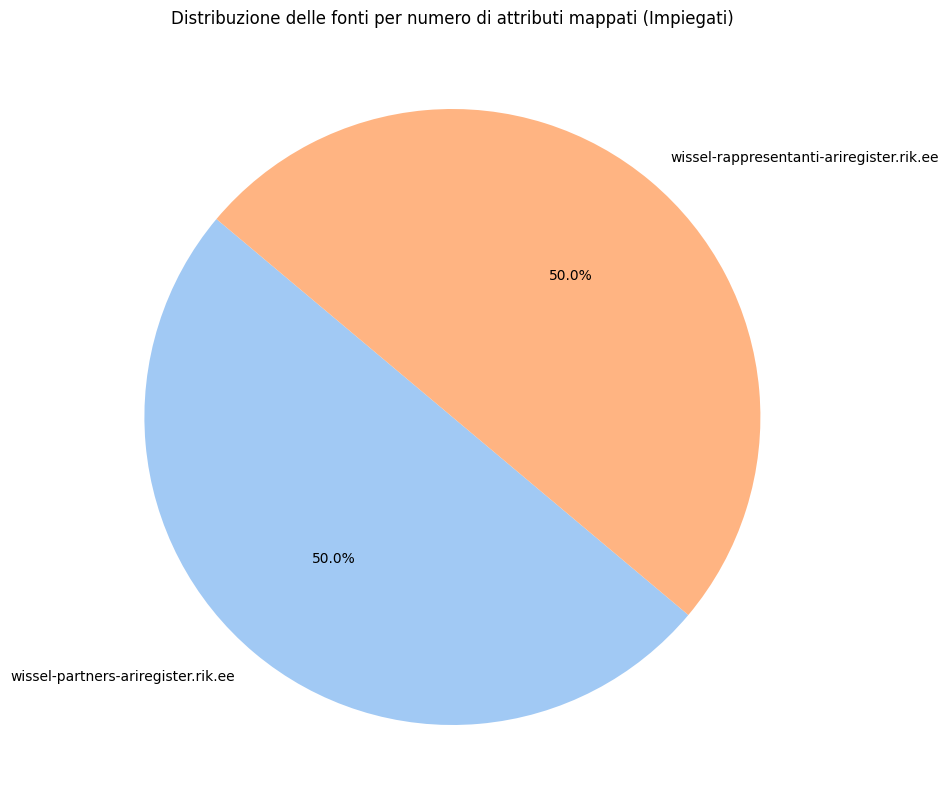

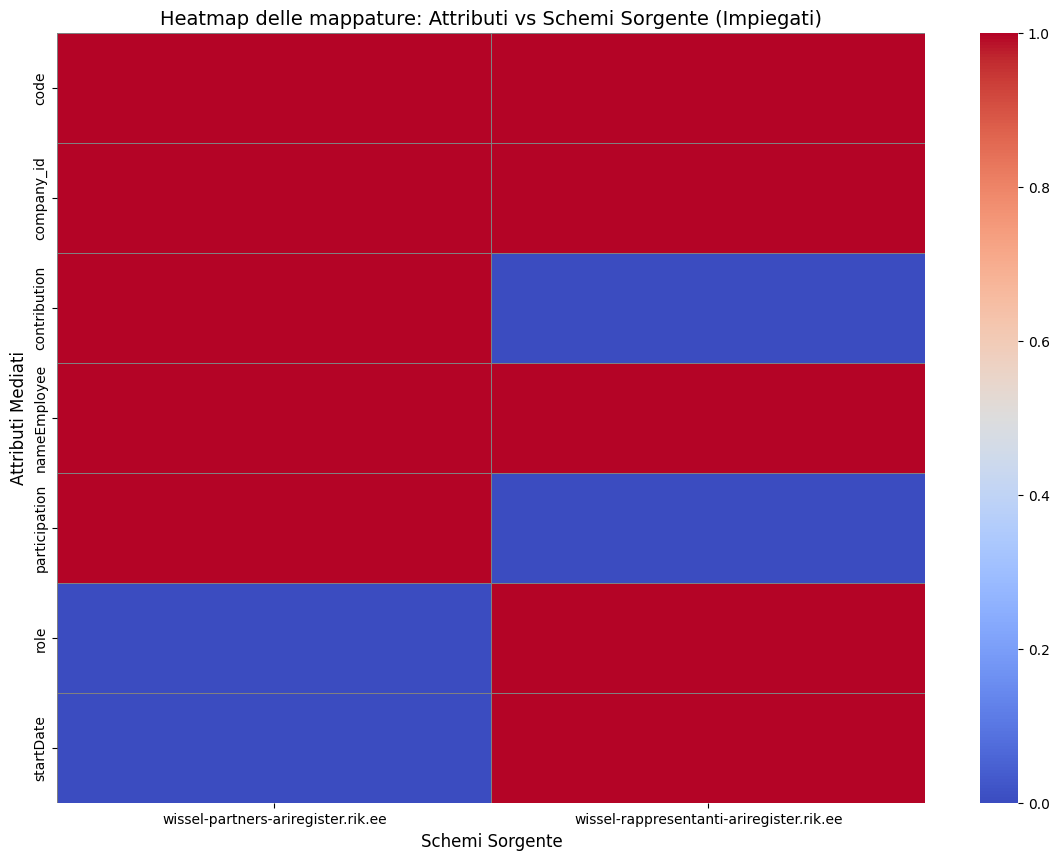

In [17]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Percorso del file JSON
json_path = "../o1-mediated/schema_mapping.json"

# Controllo se il file esiste
if not os.path.exists(json_path):
    raise FileNotFoundError(f"Il file JSON non è stato trovato: {json_path}")

# Carica il file JSON
with open(json_path, "r", encoding="utf-8") as file:
    json_data = json.load(file)

# Estrarre il mapping degli impiegati
employees_mapping = json_data.get("employees_mapping", {})

# Creazione DataFrame per analisi
mapping_list = []
for source, attributes in employees_mapping.items():
    for source_attr, mediated_attr in attributes.items():
        mapping_list.append({"source": source, "mediated_attr": mediated_attr})

df_mappings = pd.DataFrame(mapping_list)

# 🔹 Conteggio di quanti schemi sorgente hanno ogni attributo mediato
attribute_counts = df_mappings["mediated_attr"].value_counts()

# 🔹 Bar Chart: Numero di schemi sorgente per ogni attributo mediato
plt.figure(figsize=(16, 6))
sns.barplot(x=attribute_counts.index, y=attribute_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Numero di schemi sorgente per ogni attributo mediato (Impiegati)", fontsize=14)
plt.xlabel("Attributo Mediato", fontsize=12)
plt.ylabel("Numero di Schemi Sorgente", fontsize=12)
plt.yticks(range(0, max(attribute_counts.values) + 1, 1))
plt.show()

# 🔹 Pie Chart: Distribuzione delle fonti per numero di attributi
source_counts = df_mappings["source"].value_counts()

plt.figure(figsize=(10, 10))
plt.pie(source_counts, labels=source_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
plt.title("Distribuzione delle fonti per numero di attributi mappati (Impiegati)")
plt.show()

# 🔹 Heatmap: Attributi vs Fonti
heatmap_df = df_mappings.pivot_table(index="mediated_attr", columns="source", aggfunc="size", fill_value=0)

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_df, cmap="coolwarm", linewidths=0.5, linecolor="gray")
plt.title("Heatmap delle mappature: Attributi vs Schemi Sorgente (Impiegati)", fontsize=14)
plt.xlabel("Schemi Sorgente", fontsize=12)
plt.ylabel("Attributi Mediati", fontsize=12)
plt.show()


C:\Users\emigi\AppData\Local\Temp\ipykernel_18636\694830055.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=non_null_counts.index, y=non_null_counts.values, palette="viridis")


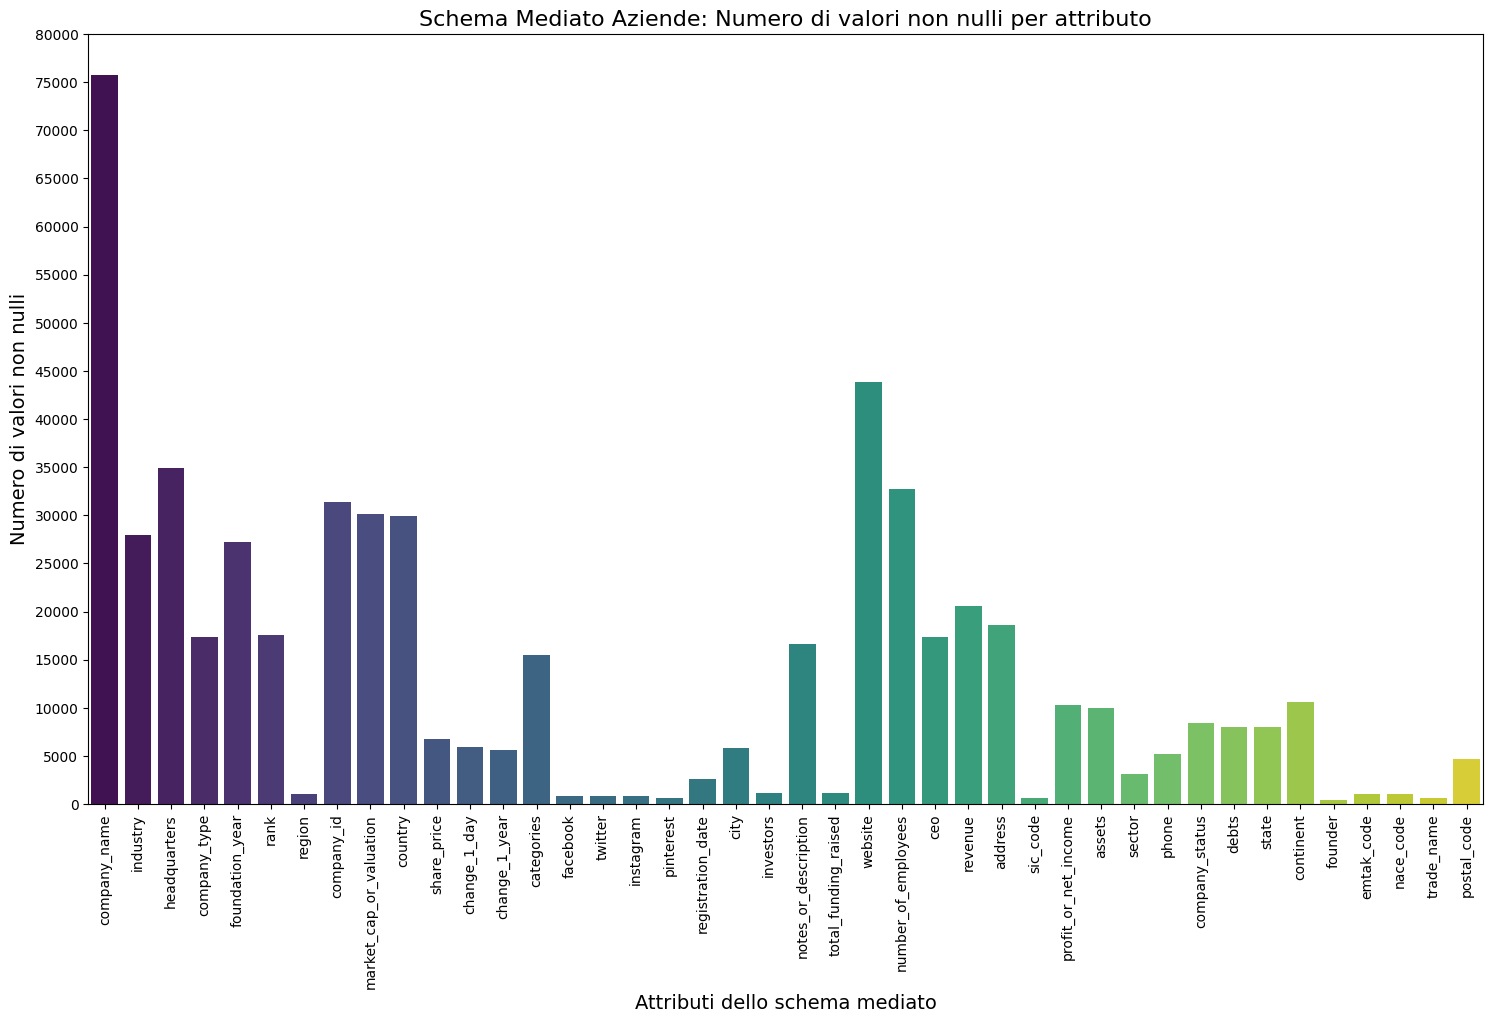

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crea un grafico a barre per rappresentare i dati non-null per ogni colonna in companies_df ed emp_df

def plot_nulls(df, title):
    # Conta i valori non nulli per ogni colonna
    non_null_counts = df.notnull().sum()

    # Crea il grafico con dimensioni maggiori
    plt.figure(figsize=(18, 10))
    ax = sns.barplot(x=non_null_counts.index, y=non_null_counts.values, palette="viridis")
    
    # Aggiungi più dettagli all'asse y
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='lower'))  # Prune 'lower' to avoid 0 overlap

    # Aumenta la granularità dell'asse y
    plt.yticks(range(0, max(non_null_counts.values) + 5000, 5000))  # Cambia 5000 con il valore desiderato per maggiore granularità
    
    # Ruota le etichette sull'asse x
    plt.xticks(rotation=90)
    plt.title(f"{title}: Numero di valori non nulli per attributo", fontsize=16)
    plt.xlabel("Attributi dello schema mediato", fontsize=14)
    plt.ylabel("Numero di valori non nulli", fontsize=14)
    plt.show()

# Grafico per il DataFrame delle aziende
plot_nulls(companies_df, "Schema Mediato Aziende")



C:\Users\emigi\AppData\Local\Temp\ipykernel_18636\1633304982.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=non_null_counts.index, y=non_null_counts.values, palette="viridis")


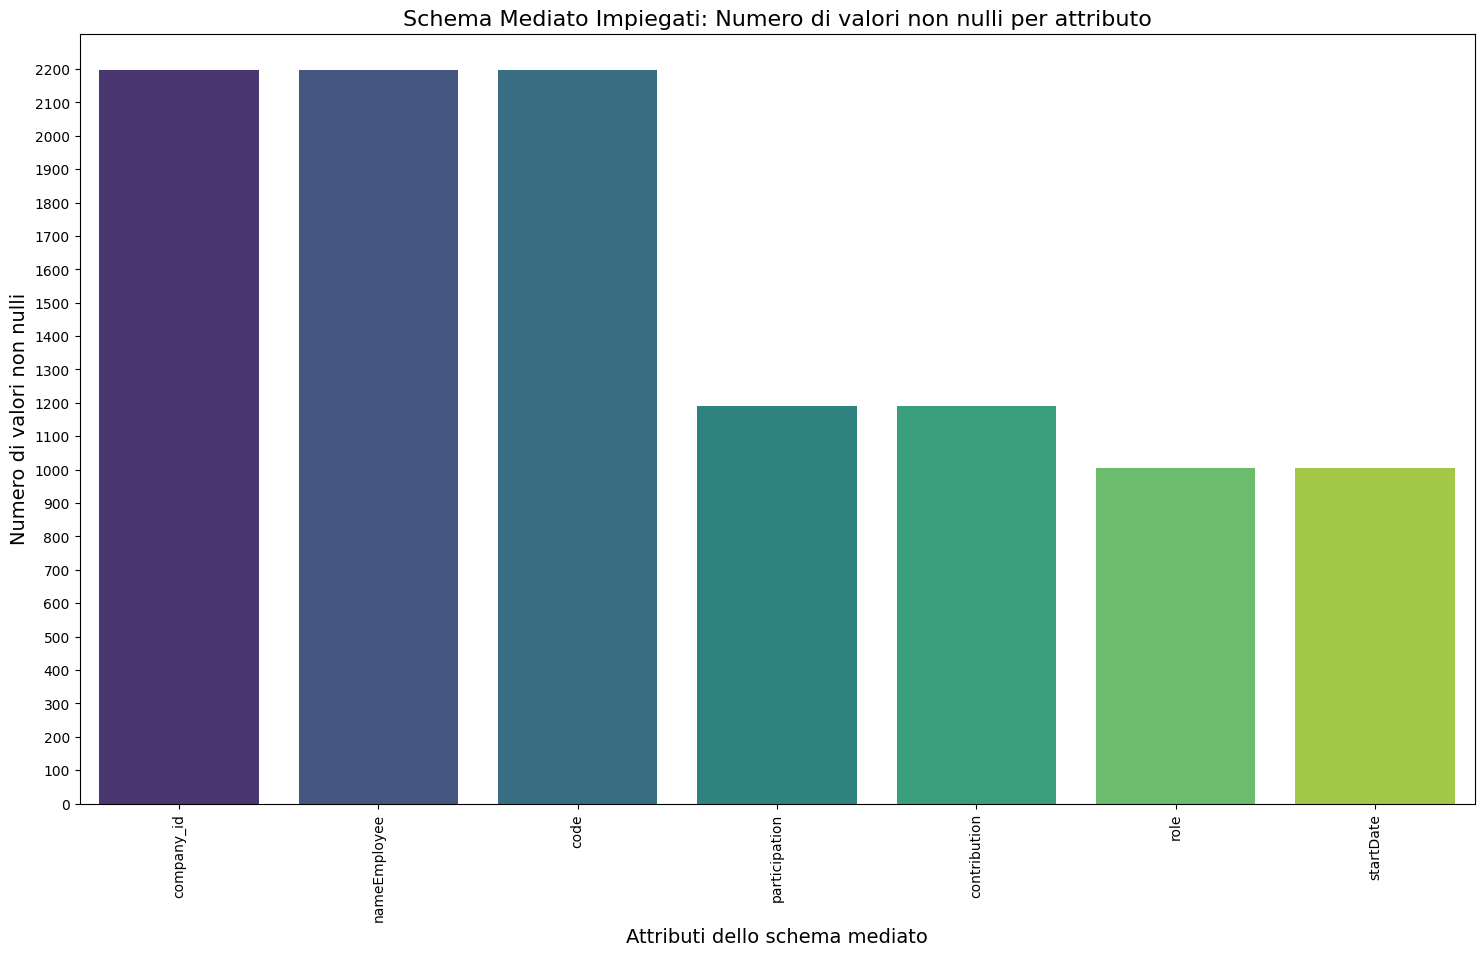

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crea un grafico a barre per rappresentare i dati non-null per ogni colonna in emp_df

def plot_nulls(df, title):
    # Conta i valori non nulli per ogni colonna
    non_null_counts = df.notnull().sum()

    # Crea il grafico con dimensioni maggiori
    plt.figure(figsize=(18, 10))
    ax = sns.barplot(x=non_null_counts.index, y=non_null_counts.values, palette="viridis")
    
    # Aggiungi più dettagli all'asse y
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='lower'))  # Prune 'lower' to avoid 0 overlap

    # Aumenta la granularità dell'asse y (ad esempio, aumentare il passo)
    plt.yticks(range(0, max(non_null_counts.values) + 100, 100))  # Cambia 1000 con il valore desiderato per maggiore granularità
    
    # Ruota le etichette sull'asse x
    plt.xticks(rotation=90)
    plt.title(f"{title}: Numero di valori non nulli per attributo", fontsize=16)
    plt.xlabel("Attributi dello schema mediato", fontsize=14)
    plt.ylabel("Numero di valori non nulli", fontsize=14)
    plt.show()

# Grafico per il DataFrame degli impiegati
plot_nulls(emp_df, "Schema Mediato Impiegati")


In [35]:
import pandas as pd

# Carica il file CSV
aziende_df = pd.read_csv("aziende.csv", encoding="utf-8")

# Trova le righe duplicate
aziende_duplicati_righe = aziende_df[aziende_df.duplicated()]

# Mostra le righe duplicate
print("Esempio di righe duplicate nel file 'aziende.csv':")
print(aziende_duplicati_righe.head())  # Mostra le prime righe duplicate (se ce ne sono)


C:\Users\emigi\AppData\Local\Temp\ipykernel_18636\1027090770.py:4: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  aziende_df = pd.read_csv("aziende.csv", encoding="utf-8")


Esempio di righe duplicate nel file 'aziende.csv':
    company_id                      company_name trade_name  industry sector categories company_status             company_type                           headquarters                                                         address postal_code city country state continent    foundation_year registration_date website rank market_cap_or_valuation number_of_employees  ceo founder assets profit_or_net_income revenue total_funding_raised share_price change_1_day change_1_year debts phone sic_code emtak_code  nace_code facebook twitter pinterest instagram investors region                           notes_or_description
5     02921121  'q' accountancy services limited        NaN       NaN    NaN        NaN         active  private limited company                                    NaN  297 stanningley road, bramley, leeds, west yorkshire, ls13 4aw         NaN  NaN     NaN   NaN       NaN      21 april 1994               NaN     NaN  NaN         

In [36]:
import pandas as pd

# Carica i file CSV
aziende_df = pd.read_csv("aziende.csv", encoding="utf-8")
impiegati_df = pd.read_csv("impiegati.csv", encoding="utf-8")

# Conta i duplicati nel file delle aziende
aziende_duplicati = aziende_df.duplicated().sum()

# Conta i duplicati nel file degli impiegati
impiegati_duplicati = impiegati_df.duplicated().sum()

# Stampa i risultati
print(f"Numero di righe duplicate nel file 'aziende.csv': {aziende_duplicati}")
print(f"Numero di righe duplicate nel file 'impiegati.csv': {impiegati_duplicati}")


C:\Users\emigi\AppData\Local\Temp\ipykernel_18636\2818764786.py:4: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  aziende_df = pd.read_csv("aziende.csv", encoding="utf-8")


Numero di righe duplicate nel file 'aziende.csv': 1482
Numero di righe duplicate nel file 'impiegati.csv': 1


C:\Users\emigi\AppData\Local\Temp\ipykernel_18636\686833446.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=null_counts.index, y=null_counts.values, palette="viridis")


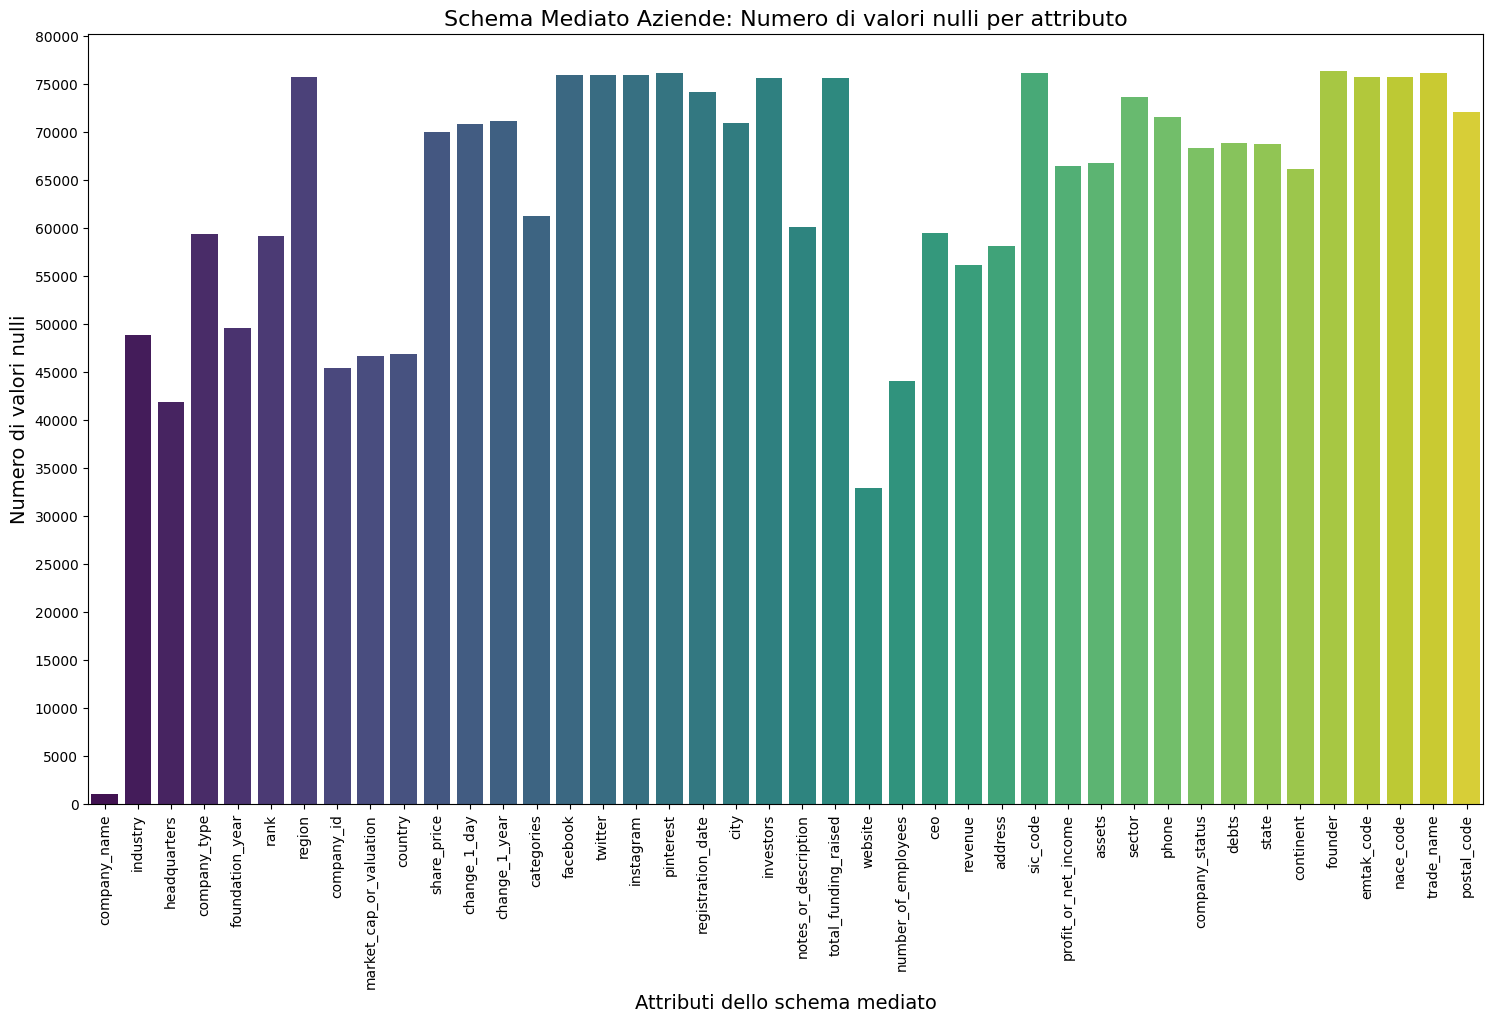

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crea un grafico a barre per rappresentare i dati nulli per ogni colonna in companies_df ed emp_df
def plot_nulls(df, title):
    # Conta i valori nulli per ogni colonna
    null_counts = df.isnull().sum()

    # Crea il grafico con dimensioni maggiori
    plt.figure(figsize=(18, 10))
    ax = sns.barplot(x=null_counts.index, y=null_counts.values, palette="viridis")
    
    # Aggiungi più dettagli all'asse y
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='lower'))  # Prune 'lower' to avoid 0 overlap

    # Aumenta la granularità dell'asse y
    plt.yticks(range(0, max(null_counts.values) + 5000, 5000))  # Cambia 5000 con il valore desiderato per maggiore granularità
    
    # Ruota le etichette sull'asse x
    plt.xticks(rotation=90)
    plt.title(f"{title}: Numero di valori nulli per attributo", fontsize=16)
    plt.xlabel("Attributi dello schema mediato", fontsize=14)
    plt.ylabel("Numero di valori nulli", fontsize=14)
    plt.show()

# Grafico per il DataFrame delle aziende
plot_nulls(companies_df, "Schema Mediato Aziende")
